# Nearest neighbour analysis

The idea of neighbourhood is one of the fundamental concepts in geographic data analysis and modelling. Being able to understand how close geographic objects are to each other, or which features are neighboring a specific location is fundamental to various spatial analysis techniques, such as spatial interpolation (which we cover in Chapter 10) or understanding whether there exist spatial autocorrelation (i.e. clustering) in the data (see Chapters [6](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html) and [7](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html) in {cite}`Rey_et_al_2023`). Many of these techniques rely on the idea that proximity in geographic space typically indicates also similarity in attribute space. For example, it is quite typical that a neighborhood with high population density is next to another neighborhood that also has high concentration of residents (i.e. the population density tend to cluster). One of the most famous notions related to this is the *First law of geography* which states that "everything is related to everything, but near things are more related than distant things" ({cite}`Tobler1970`). Thus, being able to understand how close neighboring geographic features are, or which objects are the closest ones to specific location is an important task in GIS. 

**Figure 6.43** illustrates two common ways to find nearest neighbors to specific locations. In these examples, we have two Point datasets visualized with blue circles and red rectangles that are used for doing the nearest neighbor analysis. In the first example (top row), the idea is to find the closest geometry (rectangles) for all the points in the area. Here, the nearest neighbor is determined based on distance between the points and rectangles, and the nearest neighbors are visualized with a line from every point to the closest rectangle (on the right). The bottom row shows an example in which we aim to find the closest point for each rectangle, but in this case we also apply a maximum search distance that limits the search area. Only those points that are within the search area are considered when finding the nearest neighbor, while the points outside of this area are simply ignored. As a result, the point closest to a given rectangle is visualized with a connected line (on the right). In these examples, the geographic objects are simple point like features, but similar approach can be used with any geographic features, for example by finding closest LineString or Polygon geometry to a given Point, or by finding the closest Polygon to another Polygon. In these cases, the calculations are a bit more complicated, but the basic idea is the same. 

Quite often with very large datasets, we might want to limit the search area up to a specific maximum distance. This can be due to practical reasons as it can significantly speed up the computation time, or because we have specific reasoning that makes it sensible to limit the search area. For example, if we would aim to understand how easily accessible public transportation is to citizens living in a city, it would make sense to limit the search area e.g. up to 2 km from the homes of people, because people are not willing to walk for very long distances to get into a bus stop. It's important to notice that the distances in the calculations are commonly based on the Euclidian distance, i.e. we calculate the distances based on coordinates on a Cartesian plain, meaning that the distances do not consider changes in height (i.e. third dimension is omitted). It is of course possible also to consider 3D distances, but the most typical Python tools ignore the height information. 

![_**Figure 6.43**. The basic idea of finding a nearest neighbour based on geographic distance.](../img/nearest-neighbour.png)

_**Figure 6.43**. The basic idea of finding a nearest neighbour based on geographic distance._

## Nearest neighbour analysis in Python

In Python, there are various libraries that can be used to find nearest neighbors for given set of geometries, including `shapely`, `geopandas`, `scikit-learn`, and `pysal` among others. Here, we focus on first introducing how `shapely` can be used to find the nearest neighbor for a given Point geometry, and then we show how to find nearest neighbors for all geometries in a given GeoDataFrame based on geometries in another GeoDataFrame. 

In `shapely`, we can do a simple nearest neighbour analysis between Point observations using a function called `nearest_points()` which returns a tuple of the nearest points in the input geometries.
Let's start by creating a "source" Point object and a few "destination" Points and find out which of the points in "destination" set of geometries is the closest:

In [2]:
from shapely import Point, MultiPoint
from shapely.ops import nearest_points

# Source point
orig = Point(1, 1.67)

# Destination points
dest1 = Point(0, 1.45)
dest2 = Point(2, 2)
dest3 = Point(0, 2.5)

Now we have one source point and three destination points. To be able to find out the closest destination point from the source, we need to create a MultiPoint object from the destination points:

In [3]:
destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


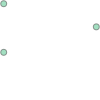

In [4]:
destinations

_**Figure 6.44**. A set of geometries represented as MultiPoint object which are used in nearest neighbor computation._

As we can see from Figure 6.44, all the destination points are represented as a single MultiPoint object. Now we can find the nearest point from the `destination` variable by using the `nearest_points()` function:

In [6]:
nearest_geometries = nearest_points(orig, destinations)
type(nearest_geometries)

tuple

As we can see, the `nearest_points()` function returns a tuple. Let's take a look at the contents of this variable: 

In [7]:
print(nearest_geoms)

(<POINT (1 1.67)>, <POINT (0 1.45)>)


In [8]:
print(nearest_geoms[0])
print(nearest_geoms[1])

POINT (1 1.67)
POINT (0 1.45)


In the tuple, the first item (at index 0) is the geometry of our source point and the second item (at index 1) is the actual nearest geometry from the destination points. Hence, the closest destination point seems to be the one located at coordinates (0, 1.45). This is the basic logic how we can find the nearest point from a set of points using `shapely`. While Shapely's `nearest_points` function provides a nice way to conduct the nearest neighbor analysis, it can be quite slow. Using it also requires taking the `unary union` of the point dataset where all the Points are merged into a single layer. This can be a really memory hungry and slow operation, that can cause problems with large point datasets. Luckily, we can do nearest neighbor analysis much more efficiently using geopandas. 

## Nearest neighbor analysis between GeoDataFrames

In the following, we go through a very practical example that relates to our daily commute: Where is the closest public transport stop from my place of living? Hence, our aim is to search for each building in the Helsinki Region the closest public transport stop. In geopandas, we can find nearest neighbors for all geometries in a given GeoDataFrame very easily by using a method called `.sjoin_nearest()`. To show how to use this method, let's start by reading two datasets representing buildings and stops into GeoDataFrames, and visualize them to understand a bit better what we have:

In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt

stops = gpd.read_file("data/Helsinki/pt_stops_helsinki.gpkg")
buildings = gpd.read_file("data/Helsinki/building_points_helsinki.zip")

print("Number of stops:", len(stops))
stops.head(2)

Number of stops: 8377


,stop_name,stop_lat,stop_lon,stop_id,geometry
0,Ritarihuone,60.16946,24.95667,1010102,POINT (24.95667 60.16946)
1,Kirkkokatu,60.17127,24.95657,1010103,POINT (24.95657 60.17127)


In [49]:
print("Number of buildings:", len(buildings))
buildings.head(2)

Number of buildings: 158731


,name,geometry
0,NaN,POINT (24.85584 60.20727)
1,Uimastadion,POINT (24.93045 60.18882)


As we can see, both GeoDataFrames contain Point geometries. There seems to be approximately 8400 stops and almost 159 thousand buildings in our data. Hence, we have already a fair amount of data and calculations to do, to find the nearest neighbor for each building. Let's still visualize the GeoDataFrames next to each other so that we can see them on a map:

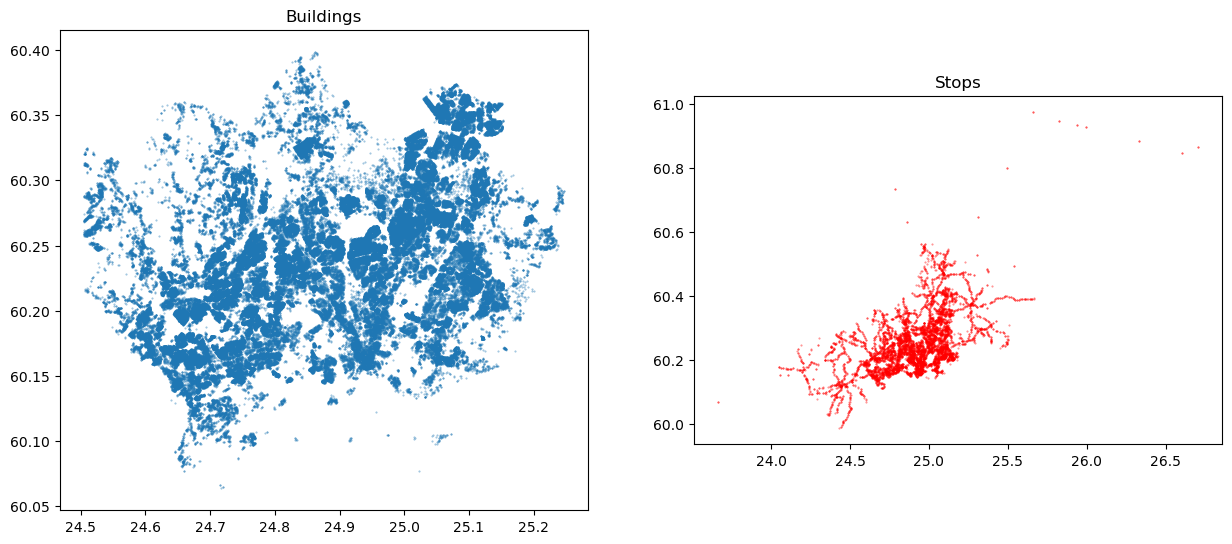

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Plot buildings
buildings.plot(ax=ax1, markersize=0.2, alpha=0.5)
ax1.set_title("Buildings")

# Plot stops
stops.plot(ax=ax2, markersize=0.2, alpha=0.5, color="red")
ax2.set_title("Stops");

_**Figure 6.45**. Maps representing the buildings and public transport stops which we use to find the closest stop for each building._

As mentioned earlier, finding the nearest geometries between two GeoDataFrames (here building and stop points) can be done easily using the `.sjoin_nearest()` method in geopandas. As the name implies, this method is actually designed to merge data between GeoDataFrames in a similar manner as with regular `.sjoin()` method that we saw earlier in Chapter 6.7. However, in this case the method is actually searching for the closest geometries instead of relying on spatial predicates, such as *within*. The `sjoin_nearest()` can be used for different geometry types, so the input geometries do not necessarily need to be Point objects as in our example. For the method to work properly, it is recommended to ensure that the both GeoDataFrames are having the same coordinate reference system (CRS), and preferably having a projected (metric) CRS because that ensures that the reported distances are meaningful (in meters) and correct. Hence, let's start by reprojecting our latitude and longitude values into a metric system using the national EUREF-FIN coordinate reference system (EPSG code 3067) for Finland:

In [51]:
stops = stops.to_crs(epsg=3067)
buildings = buildings.to_crs(epsg=3067)

stops.head(2)

,stop_name,stop_lat,stop_lon,stop_id,geometry
0,Ritarihuone,60.16946,24.95667,1010102,POINT (386623.301 6672037.884)
1,Kirkkokatu,60.17127,24.95657,1010103,POINT (386623.991 6672239.572)


Now the GeoDataFrames are surely in the same coordinate system and we can see that the coordinates in the `geometry` column have changed representing meters. Next, we will use the `buildings.sjoin_nearest()` to find the closest stop for each building. Because we are interested to find the closest stop geometry for each building, the `buildings` GeoDataFrame is the left hand side of the command. As inputs, we pass the `stops` GeoDataFrame as well as give a name for a column which is used to store information about the distance between a given building and the closest stop (this is optional):

In [54]:
%time
closest = buildings.sjoin_nearest(stops, distance_col="distance")
closest

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.2 µs


,name,geometry,index_right,stop_name,stop_lat,stop_lon,stop_id,distance
0,NaN,POINT (381166.600 6676424.438),1131,Muusantori,60.20749,24.857450,1304138,92.679893
1,Uimastadion,POINT (385236.565 6674238.472),467,Auroran sairaala,60.19145,24.925540,1171122,400.243370
2,NaN,POINT (386317.478 6672100.648),61,Senaatintori,60.16901,24.950460,1020450,109.819633
3,Hartwall Arena,POINT (385225.109 6676120.560),532,Veturitie,60.20661,24.929680,1174112,104.632434
4,Talli,POINT (385079.733 6676989.745),496,Posti 1,60.21345,24.917550,1172143,472.248282
...,...,...,...,...,...,...,...,...
158726,NaN,POINT (373896.051 6677472.204),4621,Samis,60.21369,24.720970,3170209,195.675552
158727,NaN,POINT (372425.650 6676945.528),4654,Yrjö Liipolan tie,60.20922,24.695470,3170244,137.137640
158728,NaN,POINT (374696.625 6677972.738),4655,Kandidaatintie,60.21818,24.736987,3170245,135.341745
158729,Granhultsskolan,POINT (373287.582 6677731.639),4624,Uimahalli,60.21638,24.711260,3170212,99.408108


As a result, we now have found the closest stop for each building including the attributes of the closest stops that were merged into the results. The last column in the table shows the distance in meters between a given building and the closest stop. The distance is only returned upon request as we did by specifying `distance_col="distance"`. The column `index_right` provides information about the index number of the closest stop in the `stops` GeoDataFrame. If you look carefully, you can see that the number of rows in our result has actually increased slightly from the original (158731 vs 159818). This happens because for some geometries in the `buildings` GeoDataFrame, the distance between the building and two (or more) stops have been exactly the same (i.e. they are equidistant). In such cases, the `sjoin_nearest()` will store both records into the results by duplicating the building information and attaching information from the stops into separate rows accordingly. In some cases, this can cause trouble for further analysis, so it is good to be careful and investigate whether any duplicate buildings have emerged into the results. If they have emerged, and if this causes issues in your analysis, you might need to pick one of them based on some criteria. Alternatively, you can just pick the first (or last) one if you do not have any specific justification for making the selection.

The `%time` command at the beginning of the cell provides us some details about the time it took to find the nearest neighbors and merge the data between the two GeoDataFrames. As we can see, the computations are very efficient taking only a matter of some microseconds for almost 159 thousand observations. We can make this even faster by specifying a `max_distance` parameter that specifies the maximum search distance. Here, we specify the maximum distance as 100 meters from each building:

In [53]:
%time
closest_limited = buildings.sjoin_nearest(stops, max_distance=100, distance_col="distance")
closest_limited

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11 µs


,name,geometry,index_right,stop_name,stop_lat,stop_lon,stop_id,distance
0,NaN,POINT (381166.600 6676424.438),1131,Muusantori,60.207490,24.857450,1304138,92.679893
10,NaN,POINT (384645.078 6669763.917),592,Hernesaaren laituri,60.148287,24.923281,1204101,57.786201
12,NaN,POINT (384782.782 6669707.017),595,Hernesaaren laituri,60.148680,24.924240,1204108,79.844881
13,NaN,POINT (384714.470 6669710.887),592,Hernesaaren laituri,60.148287,24.923281,1204101,32.640335
16,NaN,POINT (385040.806 6670639.517),596,Hernesaarenkatu,60.156110,24.930370,1204109,87.888087
...,...,...,...,...,...,...,...,...
158718,NaN,POINT (374219.973 6677006.100),4651,Kauniaisten asema,60.210830,24.729330,3170240,69.803673
158719,NaN,POINT (374231.494 6676967.402),4642,Kauniaistentie,60.209810,24.731510,3170230,63.384115
158720,NaN,POINT (374602.815 6677396.180),4673,Raamattuopisto,60.213524,24.736685,3170265,56.594370
158729,Granhultsskolan,POINT (373287.582 6677731.639),4624,Uimahalli,60.216380,24.711260,3170212,99.408108


As we can see, there was a slight improvement in the execution time compared to the previous call without specifying the `max_distance` parameter. The difference can be more significant if you have larger datasets or more complicated geometries (e.g. Polygons). One important aspect to notice from these results is that the number of rows has decreased significantly: from 160 to 40 thousand buildings. This happens because our search distance was very low (100 meters), and as a consequence, there were many buildings that did not have any stops within 100 meter radius from them. Because the default join type in `sjoin_nearest` is `inner` join, all the records that did not have a stop within 100 meters were dropped. If you would like to keep all the records in the results, to e.g. investigate which buildings do not have any stops within the search radius, you can add parameter `how="left"`, which will retain all buildings from the original GeoDataFrame.

In some cases, you might actually want to connect the nearest neighbors to each other with a straight line. For doing this, we need to merge also the Point geometries from the other layer into our results, which can then be used to create a LineString connecting the points to each other. This can be useful for many purposes, but in our case, we want to do this to be able to validate whether our results are correct. For merging the closest stop geometries into our results, we can take advantage of the `index_right` column in our table and conduct a normal table join using the `.merge()` method. Below, we first store the index of the `stops` GeoDataFrame into a column called `stop_index` and then use this to make a table join with our `closest` GeoDataFrame. Notice that we only keep the `stop_index` and `geometry` columns from the `stops` GeoDataFrame because all the other attributes already exist in our results: 

In [55]:
stops["stop_index"] = stops.index
closest = closest.merge(stops[["stop_index", "geometry"]], left_on="index_right", right_on="stop_index")
closest.head()

,name,geometry_x,index_right,stop_name,stop_lat,stop_lon,stop_id,distance,stop_index,geometry_y
0,NaN,POINT (381166.600 6676424.438),1131,Muusantori,60.20749,24.85745,1304138,92.679893,1131,POINT (381256.660 6676446.317)
1,Uimastadion,POINT (385236.565 6674238.472),467,Auroran sairaala,60.19145,24.92554,1171122,400.243370,467,POINT (384973.331 6674539.973)
2,NaN,POINT (386317.478 6672100.648),61,Senaatintori,60.16901,24.95046,1020450,109.819633,61,POINT (386277.250 6671998.462)
3,Hartwall Arena,POINT (385225.109 6676120.560),532,Veturitie,60.20661,24.92968,1174112,104.632434,532,POINT (385255.784 6676220.595)
4,Talli,POINT (385079.733 6676989.745),496,Posti 1,60.21345,24.91755,1172143,472.248282,496,POINT (384607.679 6677003.267)


As a result, we now brought two new columns into our results, namely `stop_index` and `geometry_y`. Because there was a column called `geometry` in both GeoDataFrames, geopandas automatically renamed the columns into `geometry_x` and `geometry_y` respectively. Now we have all the data that we need to create a connecting `LineString` between the buildings and the closest stops. We can do this by looping over the rows in our `closest` GeoDataFrame using the `.apply()` method (see Chapter 3.3 for more details) and then create the line by calling the shapely's `LineString` object which takes the Point geometries as input. We store these LineStrings into a column `geometry` which we lastly set to be the active geometry of the GeoDataFrame:    

In [63]:
from shapely import LineString
closest["geometry"] = closest.apply(lambda row: LineString([row["geometry_x"], row["geometry_y"]]), axis=1)
closest = closest.set_geometry("geometry")
closest.head()

,name,geometry_x,index_right,stop_name,stop_lat,stop_lon,stop_id,distance,stop_index,geometry_y,geometry
0,NaN,POINT (381166.600 6676424.438),1131,Muusantori,60.20749,24.85745,1304138,92.679893,1131,POINT (381256.660 6676446.317),"LINESTRING (381166.600 6676424.438, 381256.660..."
1,Uimastadion,POINT (385236.565 6674238.472),467,Auroran sairaala,60.19145,24.92554,1171122,400.243370,467,POINT (384973.331 6674539.973),"LINESTRING (385236.565 6674238.472, 384973.331..."
2,NaN,POINT (386317.478 6672100.648),61,Senaatintori,60.16901,24.95046,1020450,109.819633,61,POINT (386277.250 6671998.462),"LINESTRING (386317.478 6672100.648, 386277.250..."
3,Hartwall Arena,POINT (385225.109 6676120.560),532,Veturitie,60.20661,24.92968,1174112,104.632434,532,POINT (385255.784 6676220.595),"LINESTRING (385225.109 6676120.560, 385255.784..."
4,Talli,POINT (385079.733 6676989.745),496,Posti 1,60.21345,24.91755,1172143,472.248282,496,POINT (384607.679 6677003.267),"LINESTRING (385079.733 6676989.745, 384607.679..."


Great! Now we have created a new geometry column that contains the lines between buildings and the closest stops. To better understand the results, let's create a nice map that visualizes the buildings, stops and the connecting lines between the buildings and the closest stops in a single figure: 

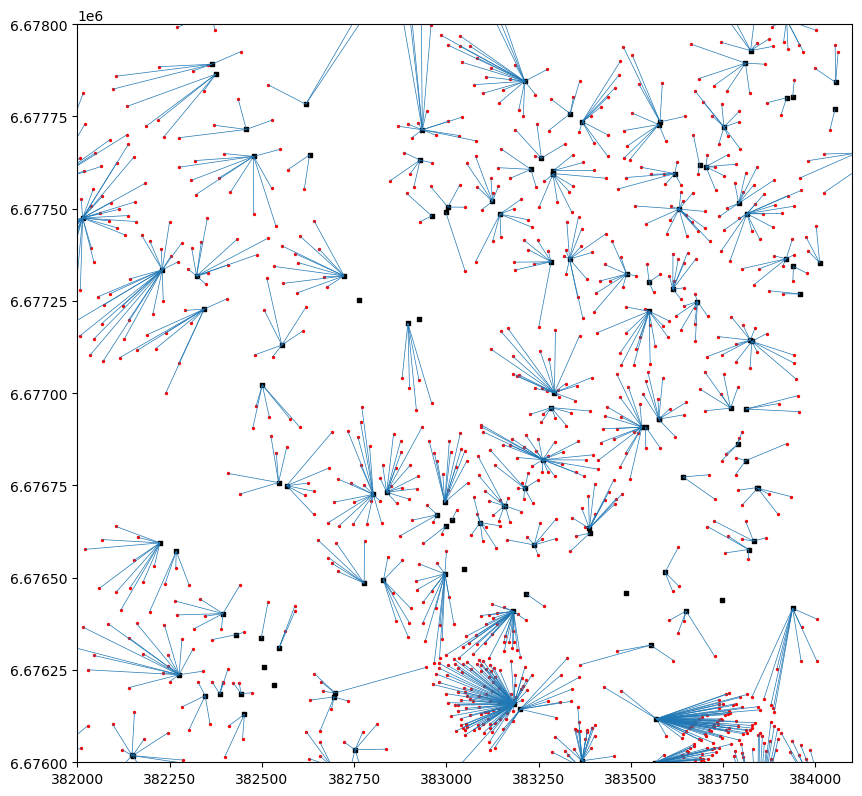

In [65]:
ax = closest.plot(lw=0.5, figsize=(10,10))
ax = buildings.plot(ax=ax, color="red", markersize=2)
ax = stops.plot(ax=ax, color="black", markersize=8.5, marker="s")
# Zoom to specific area
ax.set_xlim(382000, 384100)
ax.set_ylim(6676000, 6678000);

_**Figure 6.46**. A map showing the buildings (red points), the stops (black rectangles) and the lines between the buildings and the closest stops._

As we can see from the Figure 6.46, the nearest neighbor search have worked well as planned, and each building marked with red color has been correctly connected with a line to the closest stop. The map reveals that there are multiple isolated stops that do not have any buildings connected to them. As a practical example, this information could be used e.g. for transport planning by investigating whether these isolated stops are less used by citizens to get on board of the public transport vehicles. This information could again be used by transport planners to decide whether there is a need to maintain these isolated stops. Thus, with these rather simple computations, one can already provide useful information that has relevance in real life. Finally, because we have calculated the distance between buildings and the stops, it is easy to do some descriptive analysis based on this data providing information about levels of access to public transport in the region: 

In [66]:
closest["distance"].describe()

count    159818.000000
mean        229.029606
std         292.348698
min           0.743490
25%          99.771301
50%         163.805853
75%         260.461391
max        7698.270635
Name: distance, dtype: float64

As we can see, the average distance to public transport in the region is around 230 meters. More than 75 % of the buildings seem to be within within 3.5 minute walking time (~260 meters with walking speed of 4.5 kmph) which indicates very good situation in terms of accessibility levels in the region overall. There seem to be some really remote buildings in the data as well, as the longest distance to closest public transport stop is more than 7 kilometers.

### ADD EXAMPLE NEAREST NEIGHBOR BETWEEN POLYGONS AND LINESTRINGS

TO BE ADDED.

## K-nearest neighbor analysis

In [25]:
from sklearn.neighbors import BallTree
import numpy as np


def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric="haversine")

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    # Notice: should be in Lat/Lon format
    left_radians = np.array(
        left_gdf[left_geom_col]
        .apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180))
        .to_list()
    )
    right_radians = np.array(
        right[right_geom_col]
        .apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180))
        .to_list()
    )

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points["distance"] = dist * earth_radius

    return closest_points

Okay, now we have our functions defined. So let's use them and find the nearest neighbors!

In [26]:
# Find closest public transport stop for each building and get also the distance based on haversine distance
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric
# but useful as we get the distance between points in meters
closest_stops = nearest_neighbor(buildings, stops, return_dist=True)

# And the result looks like ..
closest_stops

,stop_name,stop_lat,stop_lon,stop_id,geometry,distance
0,Muusantori,60.20749,24.857450,1304138,POINT (24.85745 60.20749),92.374498
1,Auroran sairaala,60.19145,24.925540,1171122,POINT (24.92554 60.19145),399.238170
2,Senaatintori,60.16901,24.950460,1020450,POINT (24.95046 60.16901),109.608289
3,Veturitie,60.20661,24.929680,1174112,POINT (24.92968 60.20661),104.437950
4,Posti 1,60.21345,24.917550,1172143,POINT (24.91755 60.21345),470.640839
...,...,...,...,...,...,...
158726,Samis,60.21369,24.720970,3170209,POINT (24.72097 60.21369),195.069355
158727,Yrjö Liipolan tie,60.20922,24.695470,3170244,POINT (24.69547 60.20922),136.666774
158728,Kandidaatintie,60.21818,24.736987,3170245,POINT (24.73699 60.21818),135.041718
158729,Uimahalli,60.21638,24.711260,3170212,POINT (24.71126 60.21638),99.078476


Great, that didn't take too long! Especially considering that we had quite a few points in our datasets (8400\*159000=1.33 billion connections). As a result, we have a new GeoDataFrame that reminds a lot the original `stops` dataset. However, as we can see there are much more rows than in the original dataset, and in fact, each row in this dataset corresponds to a single building in the `buildings` dataset. Hence, we should have exactly the same number of closest_stops as there are buildings. Let's confirm this: 

In [27]:
# Now we should have exactly the same number of closest_stops as we have buildings
print(len(closest_stops), "==", len(buildings))

158731 == 158731


Indeed, that seems to be the case. Hence, it is easy to combine these two datasets together. Before continuing our analysis, let's take a bit deeper look, what we actually did with the functions above.  

### What did we just do? Explanation.

To get a bit more understanding of what just happened, let's go through the essential parts of the two functions we defined earlier, i.e. `nearest_neighbor()` and `get_closest()`.

The purpose of `nearest_neighbor()` function is to handle and transform the data from GeoDataFrame into `numpy arrays` (=super-fast data structure) in a format how `BallTree` function wants them. This includes converting the lat/lon coordinates into radians (and back), so that we get the distances between the neighboring points in a correct format: scikit-learn's [haversine distance metric](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) wants inputs as radians and also outputs the data as radians. To convert a lat/lon coordinate to radian, we use formula: `Radian = Degree * PI / 180`. By doing this, we are able to get the output distance information in meters (even if our coordinates are in decimal degrees). 

The `get_closest()` function does the actual nearest neighbor search using [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) function. We initialize the `BallTree` object with the coordinate information from the **right_gdf** (i.e. the point dataset that contains all the nearest neighbor candidates), and we specify the distance metric to be `haversine` so that we get the Great Circle Distances. The `leaf_size` parameter adjusts the tradeoff between the cost of BallTree node traversal and the cost of a brute-force distance estimate. Changing leaf_size will not affect the results of a query, but can significantly impact the speed of a query and the memory required to store the constructed tree. We determine the leaf_size as 15 which has been found to be a good compromise when [benchmarked](https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/). After we have built (initialized) the ball-tree, we run the nearest neighbor query with `tree.query(src_points, k=k_neighbors)`, where the src_points are the building-coordinates (as radians) and the `k` -parameter is the number of neighbors we want to calculate (1 in our case as we are only interested in the closest neighbor). Finally, we just re-arrange the data back into a format in which the closest point indices and distances are in separate numpy arrays. 

**Note:** The functions here assume that your input points are in WGS84 projection. If you pass the points in some other projection, it is highly likely that the distances between nearest neighbors are incorrect. Determining which is the nearest neighbor should not be affected, though.  

### Combining the neighboring datasets 

Okay, now as we have found closest stop for each building in the region, we can easily merge the information about closest stops back to the building layer. The order of the `closest_stops` matches exactly the order in `buildings`, so we can easily merge the datasets based on index. 

In [28]:
# Rename the geometry of closest stops gdf so that we can easily identify it
closest_stops = closest_stops.rename(columns={"geometry": "closest_stop_geom"})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
buildings = buildings.join(closest_stops)

# Let's see what we have
buildings.head()

,name,geometry,stop_name,stop_lat,stop_lon,stop_id,closest_stop_geom,distance
0,NaN,POINT (24.85584 60.20727),Muusantori,60.20749,24.85745,1304138,POINT (24.85745 60.20749),92.374498
1,Uimastadion,POINT (24.93045 60.18882),Auroran sairaala,60.19145,24.92554,1171122,POINT (24.92554 60.19145),399.238170
2,NaN,POINT (24.95113 60.16994),Senaatintori,60.16901,24.95046,1020450,POINT (24.95046 60.16901),109.608289
3,Hartwall Arena,POINT (24.92918 60.20570),Veturitie,60.20661,24.92968,1174112,POINT (24.92968 60.20661),104.437950
4,Talli,POINT (24.92607 60.21346),Posti 1,60.21345,24.91755,1172143,POINT (24.91755 60.21345),470.640839


Excellent! Now we have useful information for each building about the closest stop including the `distance` (in meters) and also e.g. the name of the stop in `stop_name` column. 

Now it is easy to do some descriptive analysis based on this dataset, that gives information about levels of access to public transport in the region: 

In [29]:
buildings["distance"].describe()

count    158731.000000
mean        228.708617
std         292.312344
min           0.741216
25%          99.641666
50%         163.507667
75%         259.826284
max        7684.884105
Name: distance, dtype: float64

Okay, as we can see the average distance to public transport in the region is around 300 meters. More than 75 % of the buildings seem to be within within 5 minute walking time (~370 meters with walking speed of 4.5 kmph) which indicates generally a good situation in terms of accessibility levels in the region overall. There seem to be some really remote buildings in the data as well, as the longest distance to closest public transport stop is more than 7 kilometers.

- Let's make a map out of the distance information to see if there are some spatial patterns in the data in terms of accessibility levels: